In [8]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, LayoutLMForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("impira/layoutlm-document-qa", add_prefix_space=True)
model = LayoutLMForQuestionAnswering.from_pretrained("impira/layoutlm-document-qa", dtype=torch.float16)

dataset = load_dataset(
    "parquet",
    data_files="../data/funsd/data/train-00000-of-00001.parquet",
    split="train"
)
example = dataset[0]
question = "what's his name?"
words = example["words"]
boxes = example["bboxes"]

encoding = tokenizer(
    question.split(),
    words,
    is_split_into_words=True,
    return_token_type_ids=True,
    return_tensors="pt"
)
bbox = []
for i, s, w in zip(encoding.input_ids[0], encoding.sequence_ids(0), encoding.word_ids(0)):
    if s == 1:
        bbox.append(boxes[w])
    elif i == tokenizer.sep_token_id:
        bbox.append([1000] * 4)
    else:
        bbox.append([0] * 4)
encoding["bbox"] = torch.tensor([bbox])

word_ids = encoding.word_ids(0)
outputs = model(**encoding)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits
start, end = word_ids[start_scores.argmax(-1)], word_ids[end_scores.argmax(-1)]
print(" ".join(words[start : end + 1]))

J. S. Wigand


In [6]:
from doctr.models import ocr_predictor

model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True)

In [8]:
from doctr.io import DocumentFile
path = "../data/DITrans-EMNLP/political_report/imgs/1_Is Climate Restoration an Appropriate Climate Policy Goal_01.jpg"
doc = DocumentFile.from_images(path)
result = model(doc)

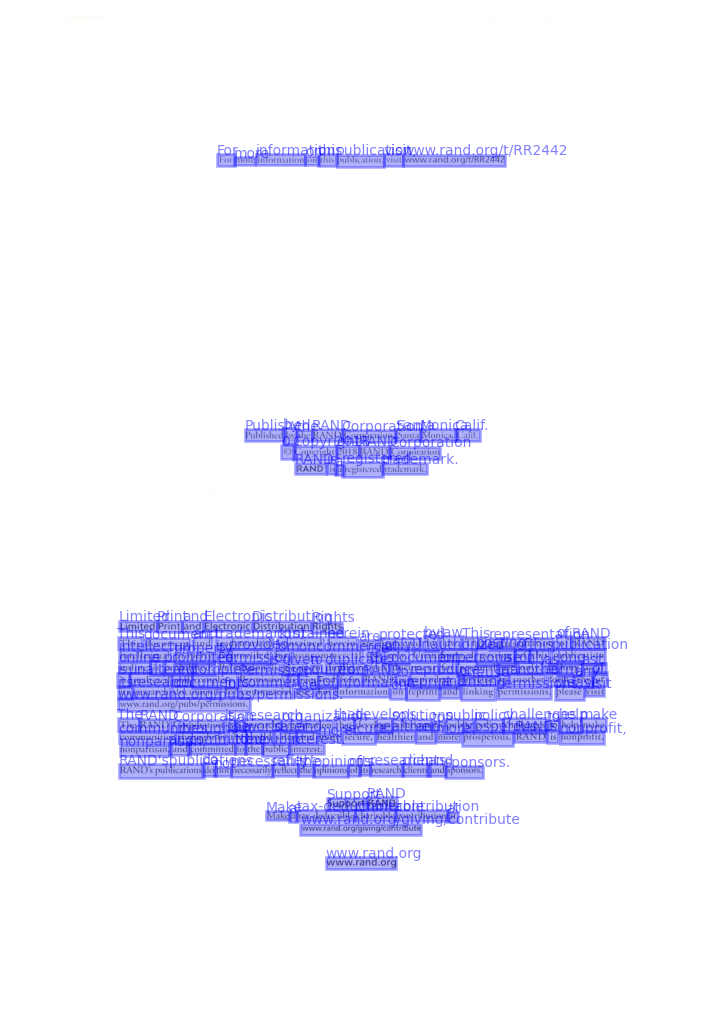

In [33]:
from doctr.utils.visualization import visualize_page

v = visualize_page(result.pages[0].export(), result.pages[0].page, interactive=False)

In [3]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs

items = load_report_with_images(limit=100)
print("Loaded:", len(items))
docs = get_docs(items)
print("Parsed:", len(docs))

Loaded: 100
Parsed: 100


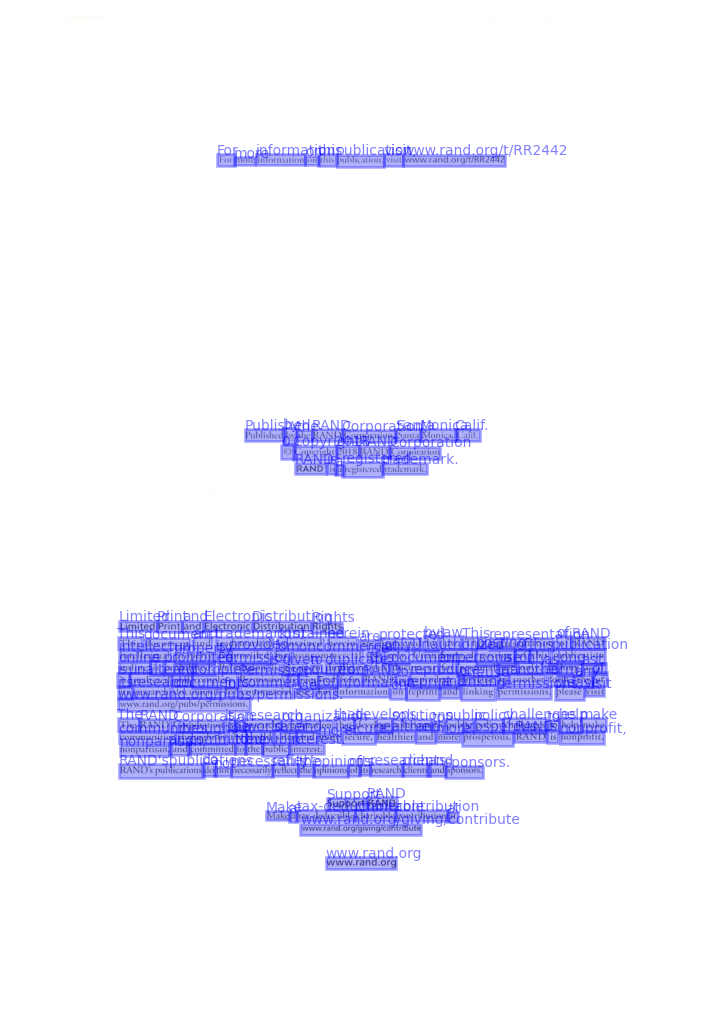

In [68]:
from doctr.io import DocumentFile
img = items[1][3]
doc = DocumentFile.from_images(img)
result = model(doc)

export = result.pages[0].export()

v = visualize_page(export, result.pages[0].page, interactive=False)

In [66]:
from tqdm import tqdm
import importlib
import segment
importlib.reload(segment)
from segment import box_contained

def parse_ocr_output(page):
    words = []
    boxes = []
    h, w = page['dimensions']
    for block in page['blocks']:
        for line in block['lines']:
            for word in line['words']:
                geometry = word['geometry']
                x_min, y_min, x_max, y_max = geometry[0][0], geometry[0][1], geometry[1][0], geometry[1][1]
                x_min, y_min, x_max, y_max = x_min * w, y_min * h, x_max * w, y_max * h
                words.append(word['value'])
                boxes.append([x_min, y_min, x_max, y_max])
    return words, boxes


items = items[:1]
docs = docs[:1]
for item, doc in tqdm(zip(items, docs), total=len(items)):
    img = item[3]
    file = DocumentFile.from_images(img)
    result = model_cuda(file)
    export = result.pages[0].export()
    words, boxes = parse_ocr_output(export)
    doc['words'] = words
    doc['boxes'] = boxes
    keys = [k for k in doc['sentences'].keys()]
    keys.sort()
    segments = [doc['sentences'][key] for key in keys]
    for i, segment in enumerate(segments):
        segment['segment_id'] = i
    doc['segments'] = segments
    doc['image_path'] = img
    labels = [-1 for _ in range(len(boxes))]
    for i, box in enumerate(boxes):
        child = {
            'x_min': box[0],
            'y_min': box[1],
            'x_max': box[2],
            'y_max': box[3]
        }
        for j, segment in enumerate(segments):
            parent = segment['box']
            if box_contained(child, parent, threshold=0.5):
                labels[i] = j
                break
    doc['labels'] = labels

100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


In [24]:
model_cuda = model.cuda()

In [67]:
docs[0]

{'sentences': {1: {'src': 'RAND',
   'tgt': '兰德公司',
   'sen_id': 1,
   'box': {'x_min': 153.5910357159947,
    'y_min': 209.98255473432644,
    'x_max': 219.79957046217172,
    'y_max': 229.03004669976124},
   'segment_id': 0},
  2: {'src': 'JUSTICE,INFRASTRUCTURE,AND ENVIRONMENT',
   'tgt': '正义、基础设施与环境',
   'sen_id': 2,
   'box': {'x_min': 235.66715604486117,
    'y_min': 201.235980661022,
    'x_max': 737.1002429242261,
    'y_max': 238.43178669820014},
   'segment_id': 1},
  3: {'src': 'Is Climate Restoration an Appropriate Climate Policy  Goal？',
   'tgt': '恢复气候是一个适当的气候政策目标吗？',
   'sen_id': 3,
   'box': {'x_min': 139.6185679040431,
    'y_min': 519.1765391181959,
    'x_max': 889.0403317059887,
    'y_max': 806.3297206871723},
   'segment_id': 2},
  4: {'src': 'Robert J. Lempert,Giacomo Marangoni ,Klaus Keller,Jessica Duke',
   'tgt': '罗伯特·J·兰佩尔，贾科莫·马兰戈尼，克劳斯·凯勒，杰西卡·杜克',
   'sen_id': 4,
   'box': {'x_min': 139.6185679040431,
    'y_min': 996.8280334493815,
    'x_max': 864.806070381